In [1]:
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
import pandas as pd

# Final Project

This notebook will provide a brief structure and rubric for presenting your final project. 

The purpose of the project is 2-fold
* To give you an opportunity to work on a problem you are truly interested in (as this is the best way to actually learn something)
* To demonstrate to me that you understand the overall workflow of problem solving from problem selection to implementation to discussion 

You can choose any subject area that interests you as long as there is a computational component to it.  However, please do not reuse projects or homeworks you have done in other classes.  This should be **your** original work.

**You can work in teams, but clearly identify each persons contribution** and every team member should hand in their own copy of the notebook.

### Structure
There are 5 parts for a total of 100 points that provide the overall structure of a mini research project.

* Problem Description
* Problem Justification
* Description of Computational components needed to address problem
* Implementation including tests
* Discussion of results and future directions

For grading purposes, please try to make this notebook entirely self contained. 

The project is worth about 2 problem sets and should be of comparable length (please: I will have about 100 of these to read and I am not expecting full 10 page papers).  The actual project does not necessarily have to work but in that case you should demonstrate that you understand why it did not work and what steps you would take next to fix it.

Have fun

## Problem Description [15 pts]

In ~4-5 paragraphs, describe the general problem you want to solve and the goals you hope to achieve. You should provide any relevant background, equations you plan to solve and references, particularly if you are reproducing results from a paper.  Please use proper spelling and grammar. 

This project would be about experimenting convolutional Gaussian processes on high dimensional problem such as image classification. The project basicly follows the idea from Wilk et al. and is trying to reproduce the similar experiments they have done with MNIST dataset in their paper. [1]

A Gaussian process (GP) is a stochastic process where every finite set of random variables follows a multivariate normal distribution. Due to the properties inherited from normal distribution, it is useful in statistical modeling as normal distribution occurs naturally in reality. Let $f(x)$ be a unknown function that we are modeling, a GP prior is then defined as 
\begin{align*}
    f(x) \sim \mathcal{GP}(m(x), k(x, x')), 
\end{align*}
where $m(x) = \mathbb{E}[f(x)]$ and $k(x, x') = \text{cov}[f(x), f(x')]$. 
This prior defines that with any $n$ inputs $X = (x_1, \cdots, x_n)$, the function gives value 
\begin{align*}
    \mathbf{f} = (f(x_1), \cdots f(x_n)) 
\end{align*}
following the multivariate normal distribution 
\begin{align*}
    \mathbf{f} \sim \mathcal{N}(m(x), k(x, x')). 
\end{align*}
Then, $k$ is called the kernel function defining the covariance of the function. It is usually assumed that we have zero mean, that is $m(x) = 0$, meaning data is normalized to zero mean. Then, in this model, if points $x_i$ and $x_j$ are considered similar by the kernel function, they should return similar values in $f(x_i)$ and $f(x_j)$. 

Let $\mathbf{f}_*$ represent the function values at the test inputs $X_*$. The joint distribution of $\mathbf{f}$ and $\mathbf{f}_*$ is then expressed as 
\begin{align*}
    \begin{bmatrix}
        \mathbf{f} \\
        \mathbf{f}_*
    \end{bmatrix} \sim 
    \mathcal{N} \left(
    \begin{bmatrix}
        m(X) \\ 
        m(X_*)
    \end{bmatrix}, 
    \begin{bmatrix}
        K & K_* \\ 
        K_*^T & K_{**}
    \end{bmatrix}
    \right), 
\end{align*}
where $K = k(X, X)$, $K_* = k(X, X_*)$, $K_{**} = k(X_*, X_*)$. 

In GP regression, we are just modeling the conditional probability $P(\mathbf{f}_* | f, X, X_*)$, where the result is 
\begin{align*}
    \mathbf{f}_* | f, X, X_* \sim \mathcal{N}(K_*^T K^{-1} \mathbf{f}, K_{**} - K_*^T K^{-1} K_*). 
\end{align*}

In this project, we want to utilize the GP regression to model the relationship between image of handwritten digits and the corresponding label of the digit. We can then convert the result of regression to the result of image classification. 

The dataset will be used in this project is MNIST, which is a large database of handwritten digits commonly used for training image processing systems. 

To reduce the computational complexity, we will be focusing on only a subset of samples of digits $0$ and $1$. Our goal is to provide a model that properly classifies any test image of handwritten $0$ or $1$ into proper category. 

We will also try the convolutional method to reduce the image size to see if we can perform the image classification using only part of the image while maintaining a high accuracy. 

## Problem Justification [5 pts] 

Briefly describe why this problem is important to you,  and, if possible, to anyone else.

This problem is important since image classification is a critical task in machine learning and computer vision. A efficient and accurate model for recognizing handwritten digits could be used to solve more complex image recognition problems. 

By using GP model, we would have a more flexible probabilistic approach to model the relationship between pixel value and corresponding label. GP regression also provides a way of giving the confidence of prediction. 

The utilization of convolutional method gives opportunity of modeling high dimensional problems such as images with larger size. 

## Computational  Methods [10 pts]

Describe the specific approach you will take to solve some concrete aspect of the general problem. 

You should  include all the numerical or computational methods you intend to use.  These can include methods or packages  we did not discuss in class but provide some reference to the method. You do not need to explain in detail how the methods work, but you should describe their basic functionality and justify your choices. 

**If you need to install or import any additional python packages,  please provide complete installation instructions in the code block below**



The main tools that will be used in this project are numpy, scikit-learn, and tensorflow. Numpy is used for computation of basic convolution method on the image. The Gaussian process regression and classification functions in Scikit-learn packaged will also be used. Tensorflow is important when we optimize the weighted convolutional GP classification. 

The MNIST dataset is from https://www.kaggle.com/datasets/avnishnish/mnist-original/data. 

In [2]:
# Provide complete installation or import information for external packages or modules here e.g.

# pip install scikit-learn
# pip install scipy
# pip install seaborn
# pip install tensorflow
# pip install tensorflow
# pip install gpflow

# Import necessary libraries
from scipy.io import loadmat
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
import gpflow
from gpflow.kernels import Kernel
from gpflow.utilities import positive

In [3]:
# Load dataset
mnist = loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]
print(mnist_data.shape)

(70000, 784)


## Implementation [60 pts]

Use the Markdown and Code blocks below to implement and document your methods including figures.  Only the first markdown block will be a grading cell but please add (not copy) cells in this section to organize your work. 

Please make the description of your problem readable by interlacing clear explanatory text with code (again with proper grammar and spelling). 
All code should be well described and commented.

For at least one routine you code below, you should provide a test block (e.g. that implements `numpy.testing` routines) to validate your code.  

An **important** component of any computational paper is to demonstrate to yourself and others that your code is producing correct results.

As mentioned previously, to reduce the computational complexity, we only focus on a subset of data of handwritten digits of $0$s and $1$s. For each sample image, we have a $28$ by $28$ array, where each element represent the pixel value on the figure. An example image is shown below. 

This is an example image of digit  0


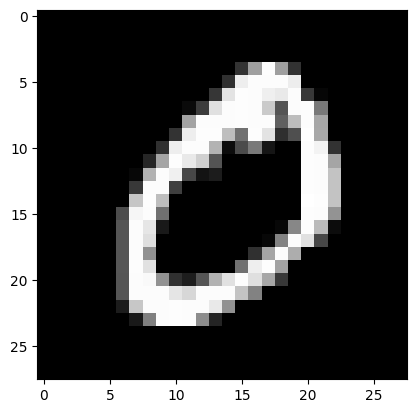

In [4]:
# Select some samples from MNIST 0 and 1
mnist_0 = mnist_data[mnist_label == 0][0:40]
mnist_1 = mnist_data[mnist_label == 1][0:40]

# Show the first image
first_image = mnist_data[0]

print("This is an example image of digit ", str(int(mnist_label[0])))
first_image = numpy.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

### Convolutional Kernel

Here we introduce the idea of convolution, which in this case is applying a filter to an image to extract the features. As we originally has a $28$ by $28$ sized image, we can apply a $m$ by $m$ patch to different regions of the image. For each $m$ by $m$ pixels, we create a pixel in our new layer based on the summation of the pixel values in this $m$ by $m$ region. 

If $g$ is a GP prior, we can present the construction mathematically by 
\begin{gather*}
    g \sim \mathcal{GP}(0, k_g(z, z')), \\
    f(x) = \sum_p g(x^{[p]}), \\
    f \sim \mathcal{GP} \left( 0, \sum_{p=1}^P \sum_{p'=1}^P k_g(x^{[p]}, x'^{[p]}) \right), 
\end{gather*}
where $x^{[p]}$ is the p-th patch in image $x$. 

In [5]:
def invariant_convolutional(input, patch_size):
    # Get the dimensions of the input
    input_shape = input.shape
    input_height = input_shape[0]
    input_width = input_shape[1]
    # input_channels = input_shape[2]

    # Get the dimensions of the patch
    patch_height = patch_size[0]
    patch_width = patch_size[1]

    # Initialize the output feature map
    output = numpy. zeros((input_height - patch_height + 1, input_width - patch_width + 1))

    # Perform the invariant convolution operation
    for i in range(input_height - patch_height + 1):
        for j in range(input_width - patch_width + 1):
            patch = input[i:i+patch_height, j:j+patch_width, :]
            output[i, j] = numpy. sum(patch)

    return output

The size of the image then becomes  (24, 24)


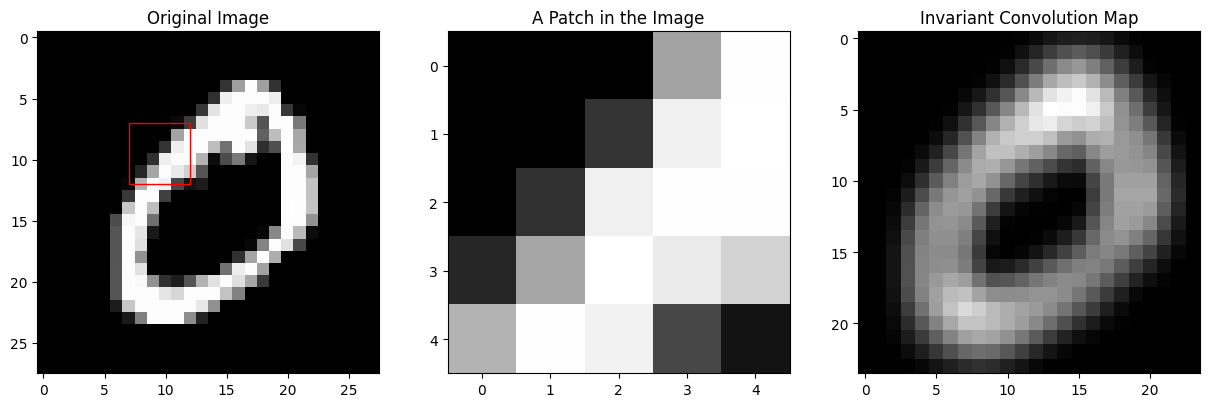

In [6]:
# Try on mnist_data
patch_size = (5, 5)
output = invariant_convolutional(mnist_data[0].reshape(28, 28, 1), patch_size)
print("The size of the image then becomes ", str(output.shape))

# Plot the original image and the output feature map side by side
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
# Create a square on the original image to show the patch
plt.imshow(mnist_data[0].reshape(28, 28), cmap='gray')
plt.gca().add_patch(plt.Rectangle((7, 7), 5, 5, edgecolor='r', facecolor='none'))
plt.title('Original Image')

# Show a patch in the image
plt.subplot(1, 3, 2)
patch = mnist_data[0].reshape(28, 28)[8:13, 8:13]
plt.imshow(patch, cmap='gray')
plt.title('A Patch in the Image')

plt.subplot(1, 3, 3)
plt.imshow(output, cmap='gray')
plt.title('Invariant Convolution Map')
plt.show()

Here we presented the effect of applying a $5$ by $5$ patch on to the original image. The red square represents one of the patches, which is presented in more detail in the second figure. The pixel values of all those $5$ by $5$ pixels are summed and beomces the value for one pixel in the third plot. We can see that by performing this transformation, we could reduce the size of the image, while keeping the original features like shapes or intensities from the original data. 

The amount of patches in a $n$ by $n$ images with patch size $m$ by $m$ should be 
\begin{align*}
    (n - m + 1) \times (n - m + 1). 
\end{align*}
In our example, our image reduces to size $24$ by $24$ from $28$ by $28$. 

### Classification

We want to test the effect of convolution on the performance of image classification. Here we use $40$ images of $0$ digits and $40$ images of $1$ digits. We split half of them into training data and half of them into testing data randomly. Since the original pixel value ranges from $0$ to $255$, we also standardized the values to avoid the effect of certain large numbers. We use the radial basis function with default scale length $1$ as the kernel function. 

In [7]:
X = numpy.vstack((mnist_0, mnist_1))
y = [0] * len(mnist_0) + [1] * len(mnist_1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=50)

# Standardize the features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Define the kernel
kernel = 1.0 * RBF(length_scale=1.0) # RBF kernel with default parameters

# Create the Gaussian process classifier
gp = GaussianProcessClassifier(kernel=kernel)

# Fit the model to the training data
gp.fit(X_train_standardized, y_train)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [8]:
# Make predictions on the test data
y_pred = gp.predict(X_test_standardized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("The accuracy on testing data is ", str(accuracy))

The accuracy on testing data is  1.0


In [9]:
print("Predicted labels: ", y_pred)

[1 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1
 1 1 1]


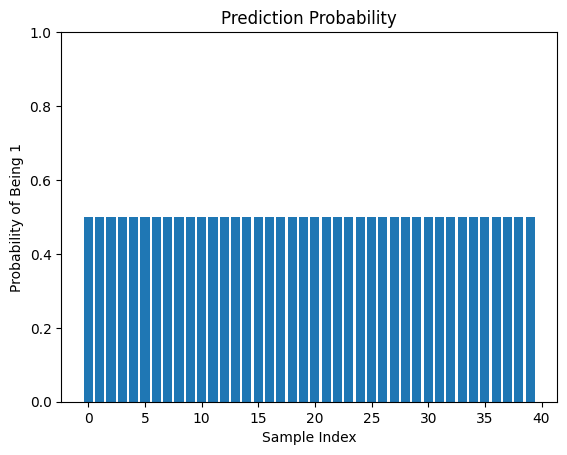

In [10]:
# Show predict probability
y_pred_prob = gp.predict_proba(X_test_standardized)
# print(y_pred_prob)

# Plot prediction probability
plt.bar(range(len(y_pred_prob)), y_pred_prob[:, 1])

# Draw a line at probability 0.5
plt.axhline(y=0.5, color='black', linewidth=0.5)

# Set y lim to 0 and 1
plt.ylim(0, 1)
plt.xlabel('Sample Index')
plt.ylabel('Probability of Being 1')
plt.title('Prediction Probability')
plt.show()

As we can see the result for the basic model is accurate, it correctly ditinguishes all the handwritten $0$ digits and $1$ digits in the $40$ testing cases. However, it is interesting that the model is not confident in it's classifications. Although the predictions are correct, the probability of being classified as $0$ or $1$ are really close. 

### Convolutional Classification

Then we will perform the same GP classification using the same images but applied with patch transformations. 

In [11]:
# Perform invariant convolution on the selected samples
patch_size = (5, 5)
X_train_conv = numpy.array([invariant_convolutional(sample.reshape(28, 28, 1), patch_size).flatten() for sample in X_train])
X_test_conv = numpy.array([invariant_convolutional(sample.reshape(28, 28, 1), patch_size).flatten() for sample in X_test])

# Standardize the features
scaler = StandardScaler()
X_train_conv_standardized = scaler.fit_transform(X_train_conv)
X_test_conv_standardized = scaler.transform(X_test_conv)

# Define the kernel
kernel = 1.0 * RBF(length_scale=1.0)  # RBF kernel with default parameters

In [12]:
# Create the Gaussian process classifier
gp = GaussianProcessClassifier(kernel=kernel)

# Fit the model to the training data
gp.fit(X_train_conv_standardized, y_train)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [13]:
# Make predictions on the test data
y_pred = gp.predict(X_test_conv_standardized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("The accuracy on testing data is ", str(accuracy))

The accuracy on testing data is  1.0


In [28]:
print("Predicted labels: ", y_pred)

[1 0 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1
 1 1 1]


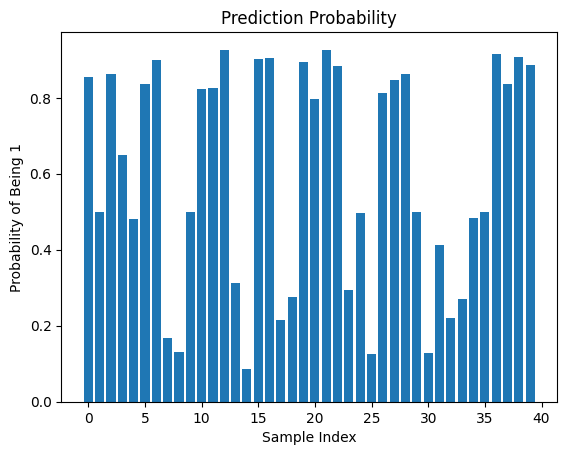

In [15]:
# Show predict probability
y_pred_prob = gp.predict_proba(X_test_conv_standardized)
# print(y_pred_prob)

# Plot prediction probability
plt.bar(range(len(y_pred_prob)), y_pred_prob[:, 1])

# Draw a line at probability 0.5
plt.axhline(y=0.5, color='black', linewidth=0.5)

plt.xlabel('Sample Index')
plt.ylabel('Probability of Being 1')
plt.title('Prediction Probability')
plt.show()

We can see that the model still maintains its high accuracy in prediction even though we are images with smaller size. It is worth noting that the model is now more confident in the classification between $0$ and $1$. As shown in the plot, most of the prediction probabilites of being $1$ is rather really high or really low. 

### Weighted Convolutional Kernel

In this part, we experiment with a different type of convolution. In the previous patch, all the pixels contribute equal weights in the summation. However, some pixels may contain more information such as those on the edges of the digits. Increasing the weights of those pixels may contribute to the result of classification. Mathematically, we change the $f(x)$ defined in the invariant convolutional case by 
\begin{align*}
    f(x) = \sum_p w_p g(x^{[p]}), 
\end{align*}
where weights$\{w_p\}_{p=1}^P$ adjusts the importance of the pixel value at each location in the image. 

In [16]:
# Set the default float type to float32 to save memory
tf.keras.backend.set_floatx('float32')
gpflow.config.set_default_float(tf.float32)

In [17]:
# Define the convolutional kernel
class Conv(Kernel):
    """
    A custom convolutional kernel for use in Gaussian Processes (GPs).
    This kernel is designed to extract patches from an input image and
    apply a base kernel to compare these patches between two images.

    Parameters:
    - basekernel: A kernel object used to compute pairwise similarities between patches.
    - img_size: Tuple specifying the dimensions of the input image (height, width).
    - patch_size: Tuple specifying the dimensions of each patch (height, width).
    - colour_channels: Number of color channels in the image (e.g., 1 for grayscale, 3 for RGB).
    """
    def __init__(self, basekernel, img_size, patch_size, colour_channels=1):
        super().__init__()
        
        self.img_size = img_size # Size of the input image
        self.patch_size = patch_size # Size of the patch
        self.basekernel = basekernel # Base kernel for comparing patches
        self.colour_channels = colour_channels # Number of color channels
        
        self.num_patches = ((self.img_size[0]- self.patch_size[0] + 1) *(self.img_size[1]- self.patch_size[1] + 1) *colour_channels) # Number of patches
        self.basekernel.active_dims = slice(0, numpy. prod(patch_size)* colour_channels) # Set active dimensions for the base kernel
        
    def _reshape_X(self, X):
        """
        Reshape the input data X into the shape required for image operations.
        Parameters:
        - X: The input tensor of shape (num_samples, num_features).
        
        Returns:
        - Tensor reshaped into (num_samples, height, width, channels).
        """
        return tf.reshape(X, (-1, self.img_size[0], self.img_size[1], self.colour_channels))
    
    def _extract_patches(self, X):
        """
        Extract patches from the input images using TensorFlow's patch extraction.
        Parameters:
        - X: The input tensor (reshaped into images).
        
        Returns:
        - A tensor of extracted patches, reshaped into 
          (num_samples, num_patches, patch_dim), where patch_dim is the flattened
          size of each patch.
        """
        # Reshape input into image format
        X_reshaped = self._reshape_X(X)
        
        # Extract patches from images using sliding windows
        patches = tf.image.extract_patches(images=X_reshaped,sizes=[1, self.patch_size[0], self.patch_size[1], 1], strides=[1, 1, 1, 1],rates=[1, 1, 1, 1], padding="VALID")

        # Flatten patches into vectors of size (patch_dim)
        patch_dim = self.patch_size[0] * self.patch_size[1] *self.colour_channels
        return tf.reshape(patches, [-1, self.num_patches,patch_dim])
    
    def K(self, X, X2=None):
        """
        Compute the covariance matrix between two sets of inputs using the convolutional kernel.
        Parameters:
        - X: The first input tensor.
        - X2: The second input tensor. Defaults to X if not provided.
        
        Returns:
        - The covariance matrix of shape (num_samples_X, num_samples_X2).
        """
        if X2 is None:
            X2 = X # If X2 is not provided, use X for self-similarity
        
        # Extract patches from both inputs
        patches_X = self._extract_patches(X)
        patches_X2 = self._extract_patches(X2)
        
        # Flatten patches for compatibility with the base kernel
        patches_X_flat = tf.reshape(patches_X, [-1, tf.shape(patches_X)[-1]])
        patches_X2_flat = tf.reshape(patches_X2, [-1, tf.shape(patches_X2)[-1]])
        
        # Compute pairwise similarities using the base kernel
        K_matrix = self.basekernel.K(patches_X_flat, patches_X2_flat)
        
        # Reshape the kernel matrix to account for patches
        K_matrix_reshaped = tf.reshape(K_matrix, [tf.shape(X)[0],self.num_patches, tf.shape(X2)[0], self.num_patches])
        
        # Compute the final kernel matrix by averaging over all patches
        return tf.reduce_sum(K_matrix_reshaped, axis=[1, 3]) / (self.num_patches ** 2)
    
    def K_diag(self, X):
        """
        Compute the diagonal of the covariance matrix (variance) for the inputs.
        Parameters:
        - X: The input tensor.
        
        Returns:
        - A tensor containing the diagonal elements of the covariance matrix.
        """
        
        # Extract patches from the input
        patches_X = self._extract_patches(X)
        
        # Flatten patches for compatibility with the base kernel
        patches_X_flat = tf.reshape(patches_X, [-1, tf.shape(patches_X)[-1]])
        
        # Compute the diagonal of the kernel matrix for each patch
        K_diag = self.basekernel.K_diag(patches_X_flat)
        
        # Sum over all patches and normalize by the number of patches
        return tf.reduce_sum(tf.reshape(K_diag, [tf.shape(X)[0], self.num_patches]), axis=1) / self.num_patches
    

In [18]:
# Convert the training and testing data to TensorFlow tensors
y_train_np = numpy. array(y_train).reshape(-1, 1)
X_train_stand_tf = tf.convert_to_tensor(X_train_standardized, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train_np, dtype=tf.float32)

In [19]:
# Define the convolutional kernel
base_kernel = gpflow.kernels.SquaredExponential()
conv_kernel = Conv(basekernel=base_kernel, img_size=(28, 28), patch_size=(5, 5))

y_train_np = numpy.array(y_train).reshape(-1, 1)
model = gpflow.models.GPR(data=(X_train_stand_tf, y_train_tf), kernel=conv_kernel, mean_function=None)
gpflow.utilities.print_summary(model)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.basekernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float32 │       1 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.basekernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float32 │       1 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float32 │       1 │
╘═══════

In [20]:
# Optimize the model
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))

In [21]:
y_test_np = numpy. array(y_test).reshape(-1, 1)
X_test_stand_tf = tf.convert_to_tensor(X_test_standardized, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test_np, dtype=tf.float32)

In [22]:
mean, var = model.predict_y(X_test_stand_tf)
pred_labels = numpy. round(mean.numpy()).astype(int)

In [ ]:
print("Predicted labels: ", pred_labels)

In [23]:
accuracy = accuracy_score(y_test, pred_labels)
print("The accuracy on testing data is ", str(accuracy))

The accuracy on testing data is  1.0


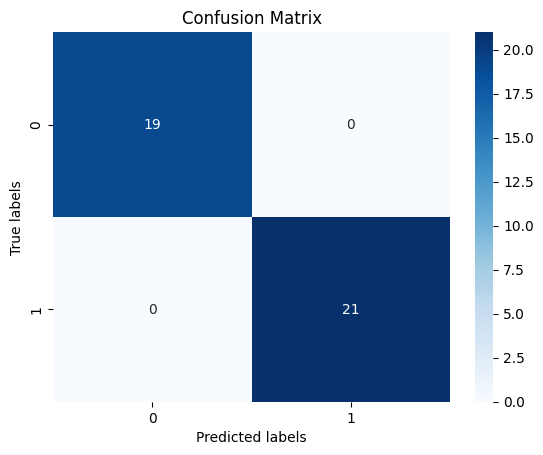

In [24]:
# Show confusion matrix
cm = confusion_matrix(y_test, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
# Convert mean to numpy array
mean_np = mean.numpy()
mean_np = mean_np.reshape(int(mean.shape[0]), 1)
mean_np = mean_np.flatten()

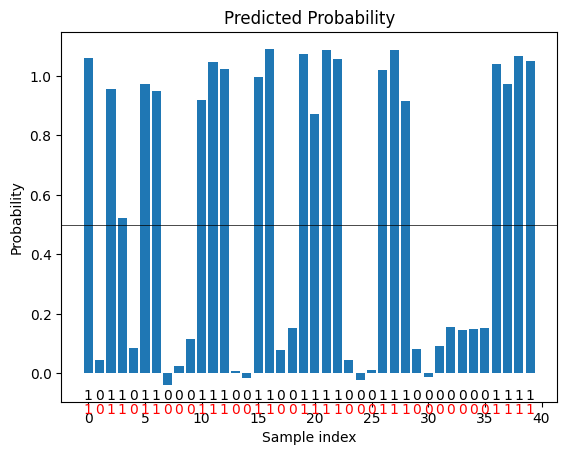

In [27]:
# Show bar plot of the probabilities
plt.bar(range(len(mean_np)), mean_np)

# # Label the correct class 
# for i in range(len(y_test)):
#     if y_test[i] == 0:
#         plt.text(i, -0.1, '0', ha='center', va='bottom')
#     else:
#         plt.text(i, -0.1, '1', ha='center', va='bottom')
        
# # Label the predicted class using red text
# for i in range(len(y_test)):
#     if pred_labels[i] == 0:
#         plt.text(i, -0.1, '0', ha='center', va='top', color='red')
#     else:
#         plt.text(i, -0.1, '1', ha='center', va='top', color='red')
        
# Draw a line at probability 0.5
plt.axhline(y=0.5, color='black', linewidth=0.5)
        
plt.xlabel('Sample index')
plt.ylabel('Predicted Mean')
plt.title('Prediction Results of Weighted Convolutional Kernel')
plt.show()


Here the prediction gives the predicted mean of each image, which explains why some of the values are greater than $1$ or smaller than $0$. We can see that the model gives more confident predictions comparing to the previous case using invariant convolutional kernel. The result shows that by applying a properly weighted convolutional kernel, we could create a better classification model. The convolutional kernel is also helpful in reducing the input size when the data has high dimension. 

## Discussion [10 pts]

Evaluate the results of your project including 
* Why should I believe that your numerical results are correct (convergence, test cases etc)?
* Did the project work (in your opinion)?
* If yes:  what would be the next steps to try
* If no:  Explain why your approach did not work and what you would do differently next time


YOUR ANSWER HERE

## Reference

1. Wilk, M., Rasmussen, C.E., Hensman, J.: Convolutional Gaussian Processes, https://arxiv.org/abs/1709.01894
2. Blomqvist, K., Kaski, S., Heinonen, M.: Deep Convolutional Gaussian Processes. arXiv:1810.03052 [cs, stat]. (2018)